----
# ResNet-50 Fine Tuning using Real World Data
-----

### Summary:
This notebook focuses on fine-tuning the pre-trained ResNet-50 model using real world images captured using Teachable Machine. The goal is to enhance performance on real-world data. 

### Data Overview:
- **Dataset:** Real World images captured using Teachable Machine
- **Number of Samples:** Approximately 300 images per letter
- **Image Dimensions:** To load images to be 64x64
 
### Notebook Overview:

- **Data Loading:**
    - Load the Real Dataset using keras
    - Split data into training and validation datasets.
    - Scale data

- **Training the ResNet Model:**
    - Load base ResNet model
    - Compile the model with loss function and optimiser.
    - Train the ResNet model on the training data and validate its performance on the validation dataset.

- **Model Evaluation:**
    - Evaluate the accuracy and performance metrics of the trained ResNet model on the validation dataset.
    - Analyse the model's performance using a confusion matrix and visualise misclassifications.

## Set Up
----

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import random

import joblib
import math


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Utility Functions
----

In [4]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''
    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

## Data Loading
----

In [5]:
directory = '../../data/my_imgs/real_world_imgs/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True, 
    seed=1
)

Found 7866 files belonging to 24 classes.


In [6]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

2024-07-07 16:58:35.190862: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Scaling images

In [7]:
for images, _ in train_data:
    images /=255

In [8]:
for images, _ in val_data:
    images /=255

## Fine-Tuning of ResNet
---

In [9]:
# load the base resnet model
fine_tuned_resnet = load_model('../../model/my_models/ResNet_model.h5')

In [10]:
# only to unfreeze the last years of the base_resnet_model
for layer in fine_tuned_resnet.layers[2:]:
    print(layer)
    layer.trainable = True

### Compiling Model

In [11]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [12]:
fine_tuned_resnet.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

In [13]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

### Training model

In [14]:
history = fine_tuned_resnet.fit(train_data,
                        batch_size = 128,
                        epochs = 50, # increasing number of epochs if too high early stopping will stop fitting early, epochs at 10 = poor data 
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/50
197/197 [==============================] - 25s 124ms/step - loss: 98.0578 - accuracy: 0.2233 - val_loss: 16.2408 - val_accuracy: 0.3032
Epoch 2/50
197/197 [==============================] - 24s 120ms/step - loss: 11.8163 - accuracy: 0.4335 - val_loss: 9.4966 - val_accuracy: 0.4984
Epoch 3/50
197/197 [==============================] - 21s 105ms/step - loss: 7.2773 - accuracy: 0.5654 - val_loss: 8.1259 - val_accuracy: 0.5671
Epoch 4/50
197/197 [==============================] - 21s 107ms/step - loss: 6.3679 - accuracy: 0.6102 - val_loss: 5.5608 - val_accuracy: 0.6720
Epoch 5/50
197/197 [==============================] - 21s 104ms/step - loss: 5.1630 - accuracy: 0.6766 - val_loss: 9.5677 - val_accuracy: 0.5416
Epoch 6/50
197/197 [==============================] - 22s 114ms/step - loss: 4.5613 - accuracy: 0.6971 - val_loss: 3.1230 - val_accuracy: 0.7559
Epoch 7/50
197/197 [==============================] - 21s 106ms/step - loss: 4.4694 - accuracy: 0.7184 - val_loss: 2.4392 - val

### Assessing train and validation accuracy

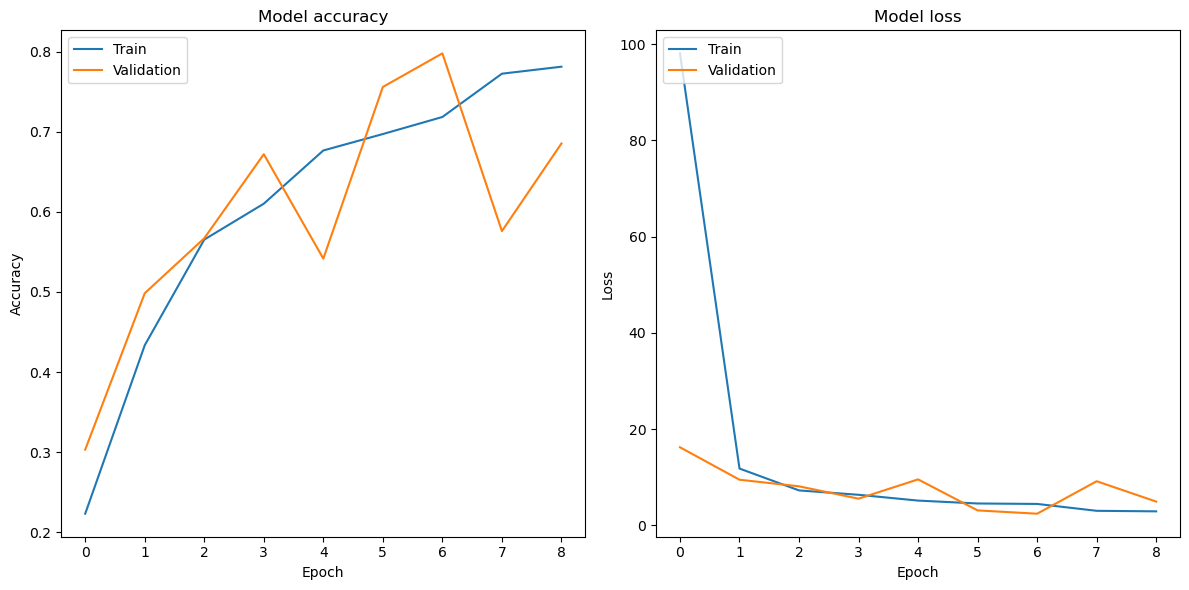

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**Comment:**

Overall it is clear taht as the number of epochs increases the accuracy and loss improve however there are some fluctuations in the validation set especially which are suspicious. My suggestion is that this is because the real world dataset only consists of 300 images per class, as ResNet is deep network with a depth 50 layers it requires a large amount of data to train well.

This is also refelcted in the lower train and validation scores (see below).

In [16]:
train_loss, train_acc= fine_tuned_resnet.evaluate(train_data)
print(f'Fine-tuned ResNet model Training Score: {round(train_acc*100,4)}')

197/197 [==============================] - 17s 85ms/step - loss: 3.9982 - accuracy: 0.7060
Fine-tuned ResNet model Training Score: 70.6023


In [18]:
val_loss, val_acc= fine_tuned_resnet.evaluate(val_data)
print(f'Fine-tuned ResNet model Validation Score: {round(val_acc*100,4)}')

 3/50 [>.............................] - ETA: 4s - loss: 5.4803 - accuracy: 0.6771

50/50 [==============================] - 5s 96ms/step - loss: 4.9562 - accuracy: 0.6853
Fine-tuned ResNet model Validation Score: 68.5315


### Saving the Model

In [19]:
fine_tuned_resnet.save('../../model/my_models/ResNet_fine_tuned.h5')

## Model Evaluation
----

In [20]:
fine_tuned_resnet = load_model('../../model/my_models/ResNet_fine_tuned.h5')

In [21]:
# getting actual labels and images from directory
labels = [] # required for confusion matrix
images = [] # required for visualising misclassifs
for imgs, actual_labels in val_data:
    # using extend to iterate and append each element to labels
    labels.extend(actual_labels.numpy())
    images.extend(imgs.numpy().astype(int))

images = np.array(images)

### Confusion Matrix

In [22]:
pred_y = np.argmax(fine_tuned_resnet.predict(val_data), axis=1)

50/50 [==============================] - 5s 80ms/step


In [23]:
conf_matrix = confusion_matrix(labels, pred_y)

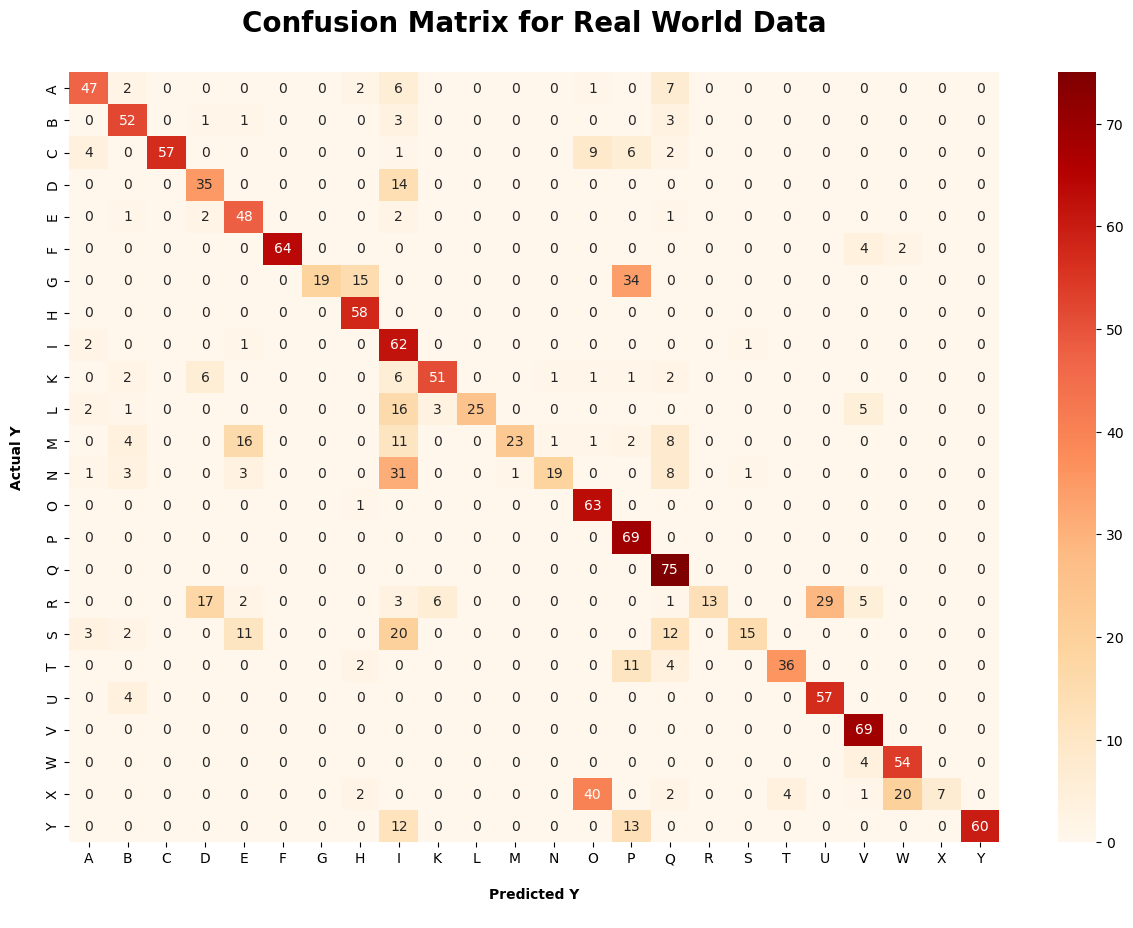

In [24]:
plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix

sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd')# -> fmt = d casting values to int
plt.title('Confusion Matrix for Real World Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(my_imgs.class_names))], my_imgs.class_names)
plt.yticks([y + 0.5 for y in range(len(my_imgs.class_names))], my_imgs.class_names)
plt.show()

**Comment:**

As expected the number of misclassifications are higher than the base resnet model since the real world dataset is not large enough for resnet to train effectively.

### Visualising Misclassifications

In [25]:
incorrect_photos = (labels != pred_y)

In [26]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [28]:
num_photos = incorrect_photos.sum()
num_photos # large sum of misclassifs

495

In [30]:
# genreate list of incorrect photos and select 15 at random to visualise
to_plot = np.where(incorrect_photos)[0]
rand_photos = random.sample(list(to_plot),15)

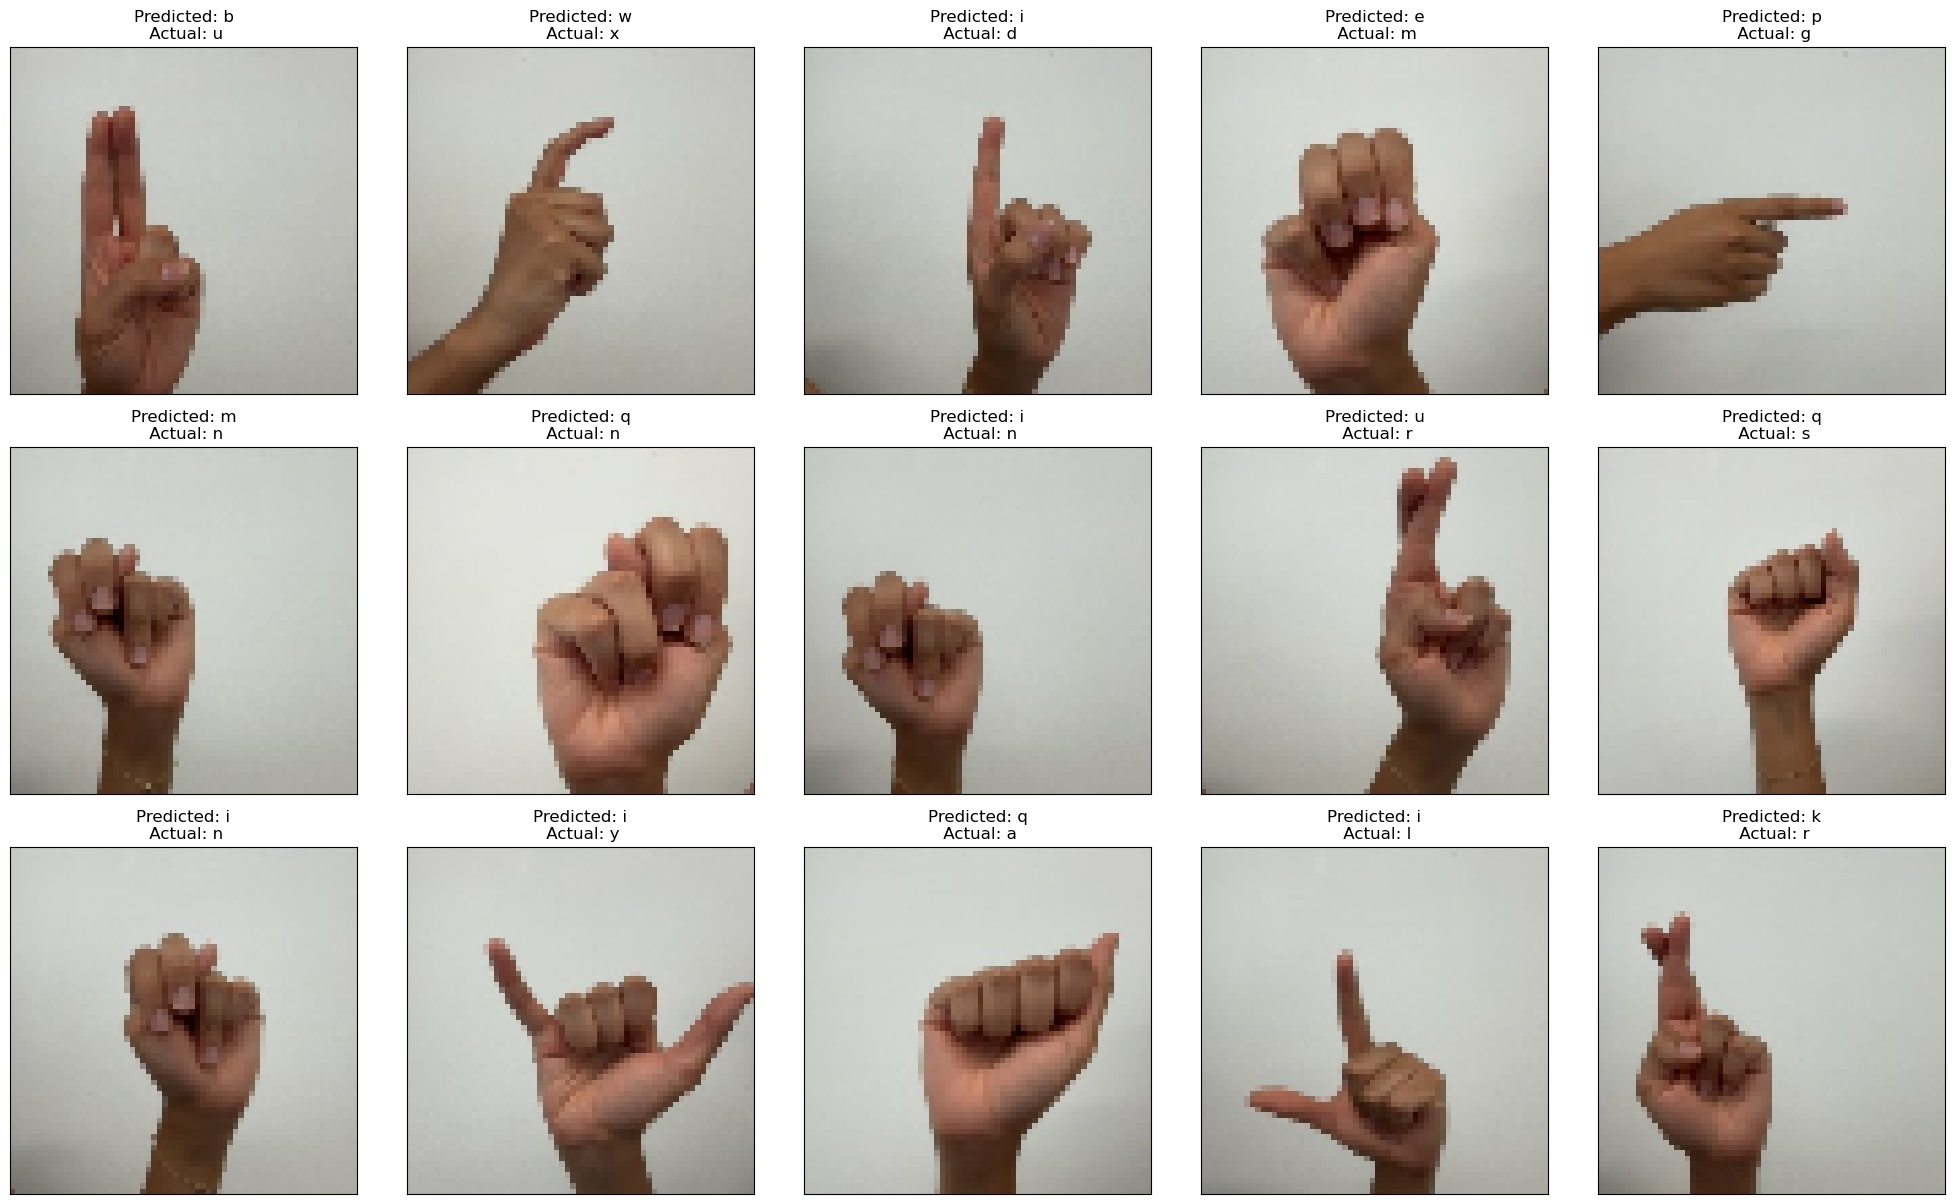

In [37]:
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20, 4*rows))

ax = axes.flatten()

if num_photos == 0:
    print('There are no misclassifications to show!')
else:

    for i, ax in enumerate(axes.flatten()):
        if i < 15:
            ax.imshow(images[rand_photos][i])

            # Get predicted label
            p = pred_y[rand_photos][i]
            prediction = alphabet[p]

            # Get actual label
            a = np.array(labels)[rand_photos][i]
            actual = alphabet[a.astype(np.int32)]

            # Set the title of the subplot
            ax.set_title(f"Predicted: {prediction}\n Actual: {actual}")

            # Hide the x and y ticks to make
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)  # Delete unused subplots           

plt.tight_layout()
plt.show()

**Comment:**

Although some images show augmentation most are well centered and clear enough for a model to classify correctly. This confirms the poor perfomance we see is likely due to to training the resnet on a dataset which isn't large enough for the model to learn effectively.

## Conclusion
-----

|                  | ResNet     | ResNet with augmentation | ResNet fine tuned |
|------------------|------------|--------------------------|-------------------|
| Train Score      | 99.99      | 89.27                    | 70.60             |
| Validation Score | 99.88      | 98.28                    | 68.53             |

Based on the results we see here, I have decided to use the VGG-16 model for my live demo to predict sign in real time as its performance was better. If I had a larger dataset I think ResNet would have outperformed VGG, in the future this is something I could try experiment with.

